In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt

In [2]:
def diff(p, dim):
    if dim==0:
        p_xdiff = p[1:,:,:] - p[:-1,:,:]
        return torch.cat((p_xdiff, p_xdiff[-2:-1,:,:]))
    elif dim==1:
        p_ydiff = p[:,1:,:] - p[:,:-1,:]
        return torch.cat((p_ydiff, p_ydiff[:,-2:-1,:]), dim=1)
    else:
        raise ValueError('Diff dimension should by either 0 or 1.')



def interpolate2d(coords, values, targets):
    Nx, Ny, Ndim = coords.shape
    Mx, My, Mdim = targets.shape
    
    # Reshape input coordinates & values, and truncate edges
    A  = coords[:-1, :-1, :].view(1, 1, Nx-1, Ny-1, Ndim)
    B  = coords[ 1:, :-1, :].view(1, 1, Nx-1, Ny-1, Ndim)
    C  = coords[:-1,  1:, :].view(1, 1, Nx-1, Ny-1, Ndim)
    D  = coords[ 1:,  1:, :].view(1, 1, Nx-1, Ny-1, Ndim)
    
    VA = values[:-1, :-1   ].view(1, 1, Nx-1, Ny-1)
    VB = values[ 1:, :-1   ].view(1, 1, Nx-1, Ny-1)
    VC = values[:-1,  1:   ].view(1, 1, Nx-1, Ny-1)
    VD = values[ 1:,  1:   ].view(1, 1, Nx-1, Ny-1)

    
    # Reshape target coordinates
    Tx = targets[:,:,0].view(Mx, My, 1, 1)
    Ty = targets[:,:,1].view(Mx, My, 1, 1)
    
    # Compute difference vectors
    AB = B - A
    AC = C - A
    DB = B - D
    DC = C - D
    
    # Seperate x- and y-variables for brevity
    Ax  =  A[:, :, :, :, 0]
    Ay  =  A[:, :, :, :, 1]
    Dx  =  D[:, :, :, :, 0]
    Dy  =  D[:, :, :, :, 1]
    
    ABx =  AB[:, :, :, :, 0]
    ABy =  AB[:, :, :, :, 1]
    ACx =  AC[:, :, :, :, 0]
    ACy =  AC[:, :, :, :, 1]
    DBx =  DB[:, :, :, :, 0]
    DBy =  DB[:, :, :, :, 1]
    DCx =  DC[:, :, :, :, 0]
    DCy =  DC[:, :, :, :, 1]

    
    # Compute coefficients
    denom_A = ABx*ACy - ABy*ACx
    b_A = ((Tx - Ax)*ACy + (Ay-Ty)*ACx) / denom_A
    c_A = ((Ax - Tx)*ABy  + (Ty-Ay)*ABx)  / denom_A
    
    denom_D = DBx*DCy - DBy*DCx
    b_D = ((Tx - Dx)*DCy + (Dy-Ty)*DCx) / denom_D
    c_D = ((Dx - Tx)*DBy  + (Ty-Dy)*DBx)  / denom_D
    
    # Mask coefficients to limit to corresponding triangles
    # Note: Each triangle ABC or DBC only corresponds with a small number of
    # target samples that lie inside that triangle. The rest of the target
    # samples is ignored by that trianlge through masking. Furthermore,
    # in order to correctly count the edges, the A- and D-masks are slightly
    # different: A uses ≥ & ≤, while D uses >. Lastly, bc_A is used both for
    # the A- and D-masks, to prevent rounding errors causing excluding or
    # counting points in both masks. Some rounding errors can still occur
    # for two nearby A- or D-triangles, though these should be virtually
    # nonexistent in practice.
    bc_A = b_A+c_A
    mask_A = torch.logical_and(torch.logical_and(b_A>=0, c_A>=0), bc_A<=1)
    mask_D = torch.logical_and(torch.logical_and(b_D>0, c_D>0), bc_A>1)
    
    # Compute interpolated values
    interp_values = torch.sum(mask_A * (VA + (VB-VA)*b_A + (VC-VA)*c_A), (2,3))\
                  + torch.sum(mask_D * (VD + (VB-VD)*b_D + (VC-VD)*c_D), (2,3))
    
    return interp_values, mask_A, mask_D


def plotresult(interp_intensities_attached, stuff_attached):
    interp_intensities = interp_intensities_attached.detach()
    intensities_attached, pscreen_attached, targets_attached, Nx, Ny, Nx_screen, Ny_screen = stuff_attached
    intensities = intensities_attached.detach()
    pscreen = pscreen_attached.detach()
    targets = targets_attached.detach()

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    fig.dpi = 80
    xc = pscreen.view(Nx*Ny, 3)[:, 0]
    yc = pscreen.view(Nx*Ny, 3)[:, 1]
    xt = targets.view(Nx_screen*Ny_screen, 2)[:, 0]
    yt = targets.view(Nx_screen*Ny_screen, 2)[:, 1]
    scat = ax1.scatter(xc, yc, s=8, c=intensities.detach(), label='Rays', vmin=0)
    plt.colorbar(scat, ax=ax1)
    ax1.plot(xt, yt, '.w', markersize=0.8, label='Output image')
    ax1.axis('equal')
    ax1.set_facecolor('black')
    legend = ax1.legend(loc=2, facecolor='#444444')
    for text in legend.get_texts():
        text.set_color("white")
    ax1.set_title('Ray positions and intensities on screen')

    plt.imshow(interp_intensities.T)
    plt.gca().invert_yaxis()
    plt.colorbar(ax=ax2)
    ax2.set_title('Output image')

    plt.show()

Initial guess: Point source position = tensor([[[ 0.0000,  0.6000, -0.3000]]])


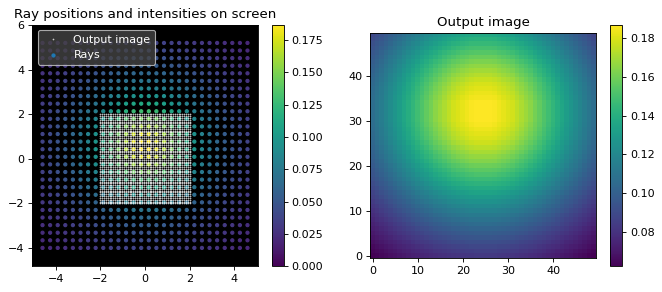

Iteration 0. Loss: 73.9
Iteration 10. Loss: 0.0717
Iteration 20. Loss: 9.21e-06
Iteration 30. Loss: 1.6e-09
Iteration 40. Loss: 4.29e-11
Iteration 49. Loss: 0


Predicted: Point source position = tensor([[[ 0.2000, -0.3000,  0.7000]]])


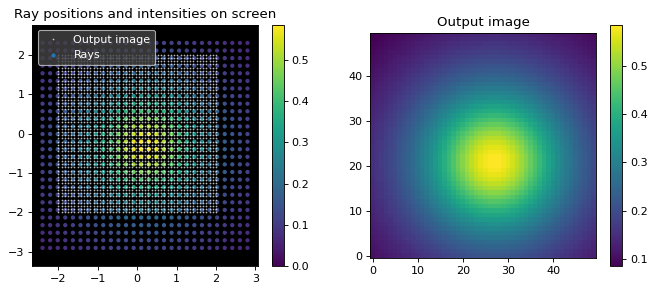

Ground truth: Point source position = tensor([[[ 0.2000, -0.3000,  0.7000]]])


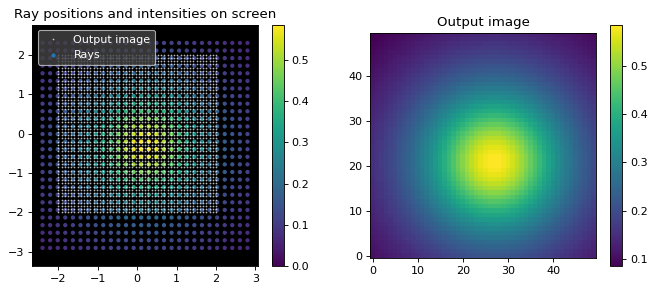

In [3]:
class RayLearner(nn.Module):
    def __init__(self, p0):
        super(RayLearner, self).__init__()
        self.p0 = nn.Parameter(p0, requires_grad=True)
        
    def forward(self):
        # Point source
        Nx = 28
        Ny = 28

        p0 = self.p0
        s0x, s0y = torch.meshgrid(torch.linspace(-2,2,Nx), torch.linspace(-2,2,Ny))
        s0z = torch.linspace(1,1,Nx)*torch.ones(Ny,Nx)
        s0 = torch.stack((s0x, s0y, s0z), 2)

        # CCD plane
        screenpoint = torch.tensor((0,0,2)).view(1,1,3)
        screennorm  = torch.tensor((0,0,-1)).view(1,1,3)

        # Compute ray intersections with screen
        d = torch.sum((screenpoint - p0)*(screennorm), dim=2, keepdim=True) / torch.sum(s0*screennorm, dim=2, keepdim=True)
        pscreen = p0 + s0*d

        ### Compute screen coordinates

        # Approximate ray density by computing cross product
        p1_xdiff = diff(s0, 0)
        p1_ydiff = diff(s0, 1)
        p1_areas = p1_xdiff.cross(p1_ydiff).norm(dim=2)

        pscreen_xdiff = diff(pscreen, 0)
        pscreen_ydiff = diff(pscreen, 1)
        pscreen_areas = pscreen_xdiff.cross(pscreen_ydiff).norm(dim=2)

        s_norm = s0.norm(dim=2)
        intensities = (1 / (s_norm*s_norm)) * (p1_areas / pscreen_areas)

        # Interpolated resampling to image
        ### Assume screen normal=-z for now
        coords = pscreen[:,:,0:2]
        Nx_screen = 50
        Ny_screen = 50
        targets = torch.stack(torch.meshgrid(\
                torch.linspace(-2,2,Nx_screen),\
                torch.linspace(-2,2,Ny_screen)), 2)

        interp_intensities, mask_A, mask_D = interpolate2d(coords, intensities, targets)
        
        return interp_intensities, intensities, pscreen, targets, Nx, Ny, Nx_screen, Ny_screen


p0 = torch.tensor((0.2,-0.3,0.7), dtype=torch.float32).view(1,1,3)
raylearner_gt = RayLearner(p0)
interp_intensities, *stuff = raylearner_gt()

criterion = nn.MSELoss(reduction='sum')
p_pred = torch.tensor((0,0.6,-0.3), dtype=torch.float32).view(1,1,3)
raylearner_train = RayLearner(p_pred)
optimizer = torch.optim.SGD(raylearner_train.parameters(), lr=4e-3)

interp_intensities_pred, *stuff_pred = raylearner_train()
print(f'Initial guess: Point source position = {raylearner_train.p0.detach()}')
plotresult(interp_intensities_pred, stuff_pred)

iterations=50
for t in range(iterations):
    # Forward pass
    interp_intensities_pred, *stuff_pred = raylearner_train()
    
    # Compute and print loss
    loss = criterion(interp_intensities_pred, interp_intensities)
    if (t%10==0) or (t==iterations-1):
        print(f"Iteration {t}. Loss: {loss.item():.3g}")
    
    optimizer.zero_grad()
    
    loss.backward(retain_graph=True)
    optimizer.step()


print('\n')
print(f'Predicted: Point source position = {raylearner_train.p0.detach()}')
plotresult(interp_intensities_pred, stuff_pred)

print(f'Ground truth: Point source position = {raylearner_gt.p0.detach()}')
plotresult(interp_intensities, stuff)

In [4]:
print(raylearner_train.p0)
print(raylearner_gt.p0)

Parameter containing:
tensor([[[ 0.2000, -0.3000,  0.7000]]], requires_grad=True)
Parameter containing:
tensor([[[ 0.2000, -0.3000,  0.7000]]], requires_grad=True)
